## PDX Stock Market Analysis Workgroup

### feature extraction / reduction / engineering

#### John Burt

My project goal is to create a model that can predict the mean stock value at a specific time in the the future. 

The goal of this notebook is test the validity of the correlate and cluster methods I used.


#### Workgroup members: 
- John Burt
- Sonny Nallamilli
- Matt Leffers
- Robert Lugg
- Purbasha Chatterjee
- Manish Kumar Saraf

Workgroup Slack channel:
https://pdxdsworkgroup.slack.com


Note: this code assumes that data files are located in same folder as notebook

data files:

http://dive-into.info/2149/stocks-us-adjClose.csv

http://dive-into.info/2149/stocks-us-moreData.zip


## Set up plot environment.

In [2]:
# remove warnings
import warnings
warnings.filterwarnings('ignore')
# ---

%matplotlib inline
import pandas as pd
pd.options.display.max_columns = 100
from matplotlib import pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
import numpy as np

from datetime import datetime

import pickle

pd.options.display.max_rows = 100

Func to load sector and industry data for a given stock symbol

from https://gist.github.com/pratapvardhan/9b57634d57f21cf3874c

NOTES: 
- have to conda install lxml
- some stocks cause error, sector & industry set to ""

In [3]:
from urllib.request import urlopen
from lxml.html import parse
#from lxml.etree import parse
#import lxml

'''
Returns a tuple (Sector, Indistry)
Usage: GFinSectorIndustry('IBM')
'''
def GFinSectorIndustry(name):
    try:
        url = 'http://www.google.com/finance?&q='+name
        tree = parse(url)
        return tree.xpath("//a[@id='sector']")[0].text, tree.xpath("//a[@id='sector']")[0].getnext().text
    except:
        #print(tree)
        return ("","")

#print(GFinSectorIndustry("IBM"))


## load data from pkl file


- Load date filled and interpolated stock market data from pkl into pandas dataframe
    - This data is generated in JMB_pdxworkgroup_feature_engineering_v3.ipynb
    - The data has been log xformed, differenced, and each time series ranges between 0-1
    
    
- load or create stock sector and industry data for each of our stocks


In [138]:
# load prepared stock time series data
diffed_filename = "stocks-us-adjClose_stocks_diffed.pkl"
try:
    with open(diffed_filename, 'rb') as handle:
        diffdata = pickle.load(handle)
    
except:
    print("error: can't load data file")

# load sector and industry data for each stock 
sector_filename = "stocks-us-adjClose_sector_industry.pkl"
try:
    with open(sector_filename, 'rb') as handle:
        stockinfo = pickle.load(handle)

    symbols = list(stockinfo.keys())
    #sector = stockinfo[1]
    #industry = stockinfo[2]
   
# file doesn't exist, so generate it
except:
    print("error: can't load sector data file, generating data...")
    
    sector = []
    industry = []
    symbols = diffdata.columns
    
    for symbol in symbols:
        sect, ind = GFinSectorIndustry(symbol)
        sector.append(sect)
        if ind.endswith(" - NEC"):
            ind = ind.replace(" - NEC", "")
        industry.append(ind)
        print("%s: %s,  %s"%(symbol,sect,ind))
        
    with open(sector_filename, 'wb') as handle:
        pickle.dump([symbols,sector,industry], handle, protocol=pickle.HIGHEST_PROTOCOL)

error: can't load sector data file, generating data...
ED: Utilities,  Electric Utilities
CVX: Energy,  Petroleum Refining
FL: Cyclical Consumer Goods & Services,  Apparel & Accessories Retailers
CAT: Industrials,  Construction Machinery
IP: Basic Materials,  Paper Packaging
SJW: Utilities,  Water Supply & Irrigation Systems
F: Cyclical Consumer Goods & Services,  Auto & Truck Manufacturers
LLY: Healthcare,  Pharmaceuticals
AVP: Non-Cyclical Consumer Goods & Services,  Personal Products
NFG: Utilities,  Natural Gas Utilities
BF-A: Non-Cyclical Consumer Goods & Services,  Distillers & Wineries
MATX: ,  
BK: Financials,  Investment Management & Fund Operators
SNE: Technology,  Household Electronics
KR: Non-Cyclical Consumer Goods & Services,  Food Retail & Distribution
BP: Energy,  Oil & Gas Refining and Marketing
C: Financials,  Banks
CL: Non-Cyclical Consumer Goods & Services,  Personal Products
APA: Energy,  Oil & Gas Exploration and Production
DDS: Cyclical Consumer Goods & Services,

PX: Basic Materials,  Commodity Chemicals
JEQ: Financials,  Closed End Funds
EQS: ,  
CCU: Non-Cyclical Consumer Goods & Services,  Brewers
TRIB: Healthcare,  Diagnostic & Testing Substances Manufacturers
MTX: Basic Materials,  Specialty Chemicals
PDCO: Healthcare,  Medical Equipment Wholesale
MIY: Financials,  Closed End Funds
QUMU: Technology,  Computer Peripherals
TCO: Financials,  Retail REITs
AAON: Industrials,  Heating, Ventilation & Air Conditioning Systems
BBOX: Telecommunications Services,  Integrated Telecommunications Services
CHK: Energy,  Oil & Gas Exploration and Production
BKN: Financials,  Investment Trusts
MS: Financials,  Investment Banking & Brokerage Services
SCVL: Cyclical Consumer Goods & Services,  Footwear Retailers
NMT: ,  
NPV: ,  
ALG: Industrials,  Agricultural Machinery
SYBT: Financials,  Commercial Banks
TCBK: Financials,  Commercial Banks
AKR: Financials,  Retail REITs
THRM: Cyclical Consumer Goods & Services,  Auto, Truck & Motorcycle Parts
BBSI: Industr

Procedure for proofing covariance/cluster analysis:

- compare stock symbol clusters between models
- compare symbol clusters by sector


## Create and fit a covariance model. 

Generates a covariance matrix, which we can use for mapping and cluster analysis.

There are several other methods, see:
http://scikit-learn.org/stable/modules/covariance.html

Note that the GraphLassoCV method creates a very sparse martix (most comparisons have a covariance of 0). This is useful for some analyses, but not if we want to generate a 2D mapping. 

Note: I'm using as inspiration: Visualizing the stock market structure
http://scikit-learn.org/stable/auto_examples/applications/plot_stock_market.html

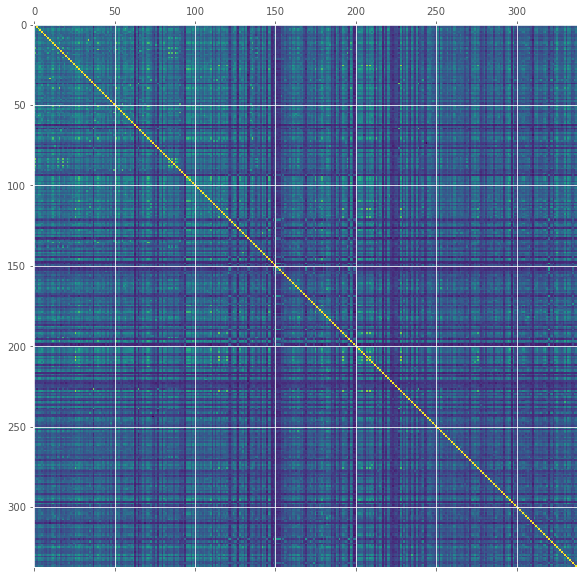

In [336]:
from sklearn import cluster, covariance, manifold

# standardize data for model
X = diffdata.copy()
X /= X.std(axis=0)

# Sparse inverse covariance
#covariance_model = covariance.GraphLassoCV(verbose=True)

# Empirical covariance
covariance_model = covariance.EmpiricalCovariance()

covariance_model.fit(X)
covmatrix = pd.DataFrame(np.array(covariance_model.covariance_, dtype=float), columns=X.columns, index=X.columns)

# set True to show the covariance matrix result
if True:
    fig, ax1 = plt.subplots(figsize=(10, 10))
    ax = ax1.matshow(covmatrix)

In [325]:
import operator

def compare_clusters(labels1, labels2, stockinfo):
    #symbols = stockinfo[0]
    symbols = np.array(list(stockinfo.keys()))
    #sector = stockinfo[1]
    #industry = stockinfo[2]
    
    # compare all cluster combos, assuming # clusters is same in both sets
    numrows = len(set(labels1))
    symbolcnt1 = np.array(np.zeros((numrows,numrows)))
    symbolcnt2 = np.array(np.zeros((numrows,numrows)))
    overlapcnt = np.array(np.zeros((numrows,numrows)))
    overlap = np.empty((numrows,numrows),dtype=object)

    # compare cluster pairs, make some stats
    for i in range(numrows):
        clset1 = symbols[labels1 == i]
        for j in range(i+1):
            clset2 = symbols[labels2 == j]
            if i != j:
                symbolcnt1[i,j] = len(clset1)
                symbolcnt2[i,j] = len(clset2)
                overlap[i,j] = np.array(list(set(clset1).intersection(clset2)))
                overlapcnt[i,j] = overlap[i,j].shape[0]
                
                if False:
                #if overlapcnt[i,j] > 0:
                    print("\n%d vs %d, %d overlapped:"%(i,j,overlapcnt[i,j]))
                    print(clset1)
                    print(clset2)
                    print(overlap[i,j])

                symbolcnt1[j,i] = symbolcnt1[i,j]
                symbolcnt2[j,i] = symbolcnt2[i,j]
                overlap[j,i] = overlap[i,j]
                overlapcnt[j,i] = overlapcnt[i,j]
    
    # find best overlap pairings
    #print("best overlap:")
    bestoverlap = []
    oc = []
    for i in range(numrows):
        max_index, max_value = max(enumerate(overlapcnt[i,:]), key=operator.itemgetter(1))
        bestoverlap.append(max_index)
        oc.append(overlapcnt[i,max_index] / min(symbolcnt1[i,max_index], symbolcnt2[i,max_index]))
        #print("%d vs %d: ol=%d out of %d,%d, oc=%1.3f" % 
        #      (i,max_index, 
        #       overlapcnt[i,max_index],
        #       symbolcnt1[i,max_index], symbolcnt2[i,max_index],
        #       overlapcnt[i,max_index] / min(symbolcnt1[i,max_index], symbolcnt2[i,max_index])
        #      ))
        #olsectors = list([stockinfo[x][0] for x in overlap[i,max_index] ])
        #sectset = list(set(olsectors))
        #sectset.sort()
        #for s in sectset:
        #    print("\t%s = %d"%(s,olsectors.count(s)))
        
    print("mean oc = %1.3f"%(np.mean(oc)))
    
    return bestoverlap, oc
        
    

In [345]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

def map_and_cluster(covmatrix, mapmodel, numclusters=10):
    # get the coordinates we need
    coords = mapmodel.fit_transform(covmatrix)       
    # rotate coordinate space for best alignment
    # Rotate the data
    clf = PCA(n_components=coords.shape[1])
    coords = clf.fit_transform(coords)
    # cluster 
    kmeans = KMeans(n_clusters=numclusters).fit(coords)
    centroids = kmeans.cluster_centers_
    labels = kmeans.labels_
    
    return coords, labels, centroids
    

In [346]:

def pairwise_compare_clustering(covmatrix, mapmodel1, mapmodel2, stockinfo, numclusters=10):
    
    print("\ncomparing models: %s vs %s, %d dims, %d clusters" % 
          (type(mapmodel1).__name__, type(mapmodel2).__name__, numdims, numclusters))
    
    coords1, labels1, centroids1 = map_and_cluster(covmatrix, mapmodel1, numclusters)
    coords2, labels2, centroids2 = map_and_cluster(covmatrix, mapmodel2, numclusters)
        
    # compare the two clustering results
    bestoverlap, oc = compare_clusters(labels1, labels2, stockinfo)
    
    

compare clusterings from several mapping models

In [347]:
if False:

    numdims=2
    numclusters=10

    mapmodels = {
        "LLE" : manifold.LocallyLinearEmbedding(n_components=numdims, eigen_solver='dense', n_neighbors=50),
        "TSNE" : manifold.TSNE(n_components=numdims),
        "MDS" : manifold.MDS(n_components=numdims),
        "SE"  : manifold.SpectralEmbedding(n_components=numdims)
        }

    numrows = len(mapmodels.keys())
    for i in range(numrows):
        model1 = list(mapmodels.values())[i] 
        for j in range(i+1):
            model2 = list(mapmodels.values())[j] 
            if i != j:
                pairwise_compare_clustering(covmatrix, model1, model2, stockinfo, numclusters=numclusters)


look at clustering within each model:

- generate a score of specificity of each cluster 
- what cluster size gives best specificity?


In [348]:
from operator import itemgetter
def sorti(x):
    #i = np.argsort(x)
    #return x[i], i
    return zip(*sorted([(i,e) for i,e in enumerate(x)], key=itemgetter(1)))


In [349]:

# testing out sort indexing methods
if False:
    symbols = np.array(list(stockinfo.keys()))
    # get count of stocks in each sector
    labelsectors = list([stockinfo[x][0] for x in symbols ])
    #print(labelsectors)
    labelsectset = np.array(list(set(labelsectors)))
    np.sort(labelsectset)
    sectorcount = np.array([labelsectors.count(s) for s in labelsectset])
    ci = np.argsort(-sectorcount)
    labelsectset = labelsectset[ci]
    sectorcount = sectorcount[ci]
    for s,c in zip(labelsectset,sectorcount): print(s,"\t",c)



In [350]:


def analyze_sector_clustering(coords, labels, centroids, stockinfo):
    symbols = np.array(list(stockinfo.keys()))
    #industry = stockinfo[2]
    
    # number of clusters
    numclusters = len(set(labels))
    
    # get count of stocks in each sector
    labelsectors = list([stockinfo[x][0] for x in symbols ])
    labelsectset = list(set(labelsectors))
    labelsectset.sort()
    #sectorcount = list([labelsectors.count(s) for s in labelsectset])
    print("\n\n%d clusters:"%(numclusters) )

    # look at each cluster
    for i in range(numclusters):
        # symbols in cluster i
        clsymbols = symbols[labels == i]
        print("\nCluster %d, %d symbols: "%(i, len(clsymbols)), end="")
        clsectors = list([stockinfo[x][0] for x in clsymbols ])
        sectset = list(set(clsectors))
        #sectorscore = np.array(list([clsectors.count(s)/labelsectors.count(s) for s in sectset]) )
        sectorscore = np.array(list([clsectors.count(s)/len(clsymbols) for s in sectset]) )
        ci = np.argsort(sectorscore)[::-1]
        for j in range(min(3,ci.shape[0])):
        #for j in range(ci.shape[0]):
            print("%s(%1.2f), "%(sectset[ci[j]],sectorscore[ci[j]]), end="")
        #print("\n")
        
#        for s in sectset:
#            sectcount = labelsectors.count(s)
#            clcount = clsectors.count(s)
#            sectorscore = clcount/sectcount
#            print("\t%s %d/%d, score=%1.2f"%(s,clcount,sectcount,sectorscore))
        
    

In [351]:
if True:
    numdims=3
    #numclusters=list(range(6,13,2))   
    numclusters=[12]   

    mapmodels = {
        "LLE" : manifold.LocallyLinearEmbedding(n_components=numdims, eigen_solver='dense', n_neighbors=50),
        "TSNE" : manifold.TSNE(n_components=numdims),
        "MDS" : manifold.MDS(n_components=numdims),
        "SE"  : manifold.SpectralEmbedding(n_components=numdims)
        }
    
    for mapkey in mapmodels:
        mapmodel = mapmodels[mapkey]
        for nclusters in numclusters:
            coords, labels, centroids = map_and_cluster(covmatrix, mapmodel, nclusters)
            analyze_sector_clustering(coords, labels, centroids, stockinfo)
            




12 clusters:

Cluster 0, 15 symbols: Financials(0.20), Non-Cyclical Consumer Goods & Services(0.20), Healthcare(0.13), 
Cluster 1, 35 symbols: Financials(0.29), Technology(0.17), Industrials(0.11), 
Cluster 2, 25 symbols: Financials(0.40), Non-Cyclical Consumer Goods & Services(0.16), Healthcare(0.12), 
Cluster 3, 20 symbols: Cyclical Consumer Goods & Services(0.35), Financials(0.20), Industrials(0.15), 
Cluster 4, 33 symbols: (0.21), Financials(0.18), Cyclical Consumer Goods & Services(0.15), 
Cluster 5, 34 symbols: Financials(0.29), Cyclical Consumer Goods & Services(0.15), Technology(0.15), 
Cluster 6, 38 symbols: Financials(0.24), Industrials(0.18), Technology(0.13), 
Cluster 7, 19 symbols: Financials(0.58), Cyclical Consumer Goods & Services(0.11), Energy(0.11), 
Cluster 8, 20 symbols: Financials(0.35), Healthcare(0.20), Industrials(0.20), 
Cluster 9, 34 symbols: Financials(0.26), Technology(0.15), Healthcare(0.12), 
Cluster 10, 35 symbols: Financials(0.29), Industrials(0.17), C

## Map the covariance matrix onto a 2D space. 

Ideally, the covariance matrix mapping will yield a clustering of stocks that have similar historical behavior.

Note that I have tried several mapping methods. The one used here is [t-distributed Stochastic Neighbor Embedding (t-SNE)](http://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html#sklearn.manifold.TSNE), which generates a good looking map. Whether this map is meaningful, or whether some other method is better, will require further proofing.

For more on this see:
http://scikit-learn.org/stable/modules/manifold.html

However, it is possible that there are other better mappings, or that some mapping will work better if the default parameters are further tweaked.

In [352]:
# #############################################################################
# Find a low-dimension embedding for visualization and cluster analysis: 
# find the best position of the nodes (the stocks) on a 2D plane

# alternate mapping models:
#node_position_model = manifold.LocallyLinearEmbedding(
#    n_components=2, eigen_solver='dense', n_neighbors=50)
#node_position_model = manifold.MDS()
#node_position_model = manifold.SpectralEmbedding()

# this seems to work best
# note that the default # dimensions are 2 - you could have more if you want
node_position_model = manifold.TSNE()

# get the 2D coordinates we need
coords = node_position_model.fit_transform(edge_model.covariance_)

## Cluster analysis

Use Kmeans clustering to identify a specified number of groups of correlated stocks. 

These stock groupings will be used to generate our features.

Note that there are many other clustering methods, including ones that decide on their own how many clusters to generate. I chose kmeans because it is straighforward and common, it returns exactly the number of clusters you choose, and it returns cluster centroids, which I will then use in feature generation. 

See:
http://scikit-learn.org/stable/modules/clustering.html

In [353]:
from sklearn.cluster import KMeans

names = X.columns
symbols = X.columns

numclusters = 10
kmeans = KMeans(n_clusters=numclusters).fit(coords)
centroids = kmeans.cluster_centers_
labels = kmeans.labels_

n_labels = labels.max()

for i in range(n_labels + 1):
    print('Cluster %i: contains %d stocks: %s\n' % 
          ((i + 1), len((names[labels == i])), ', '.join(names[labels == i])))

Cluster 1: contains 35 stocks: BK, C, VNO, WABC, BAC, TRC, JPM, BBT, FHN, CVBF, FMBI, TRST, LM, CBU, BDN, FBNC, WASH, KEY, CHFC, NBTB, STBA, TCO, MS, SYBT, TCBK, AKR, CPT, EQR, UBSH, AF, HIW, UVSP, FII, GBL, BLK

Cluster 2: contains 35 stocks: LUB, ADI, VLGEA, CY, AVNW, TECH, EA, ZIXI, KOPN, CACC, BBOX, ADTN, UHAL, KFRC, AVX, WAT, PRXL, CSGS, NCI, NUS, VSAT, AMZN, HCKT, CSGP, BCOR, EPAY, EXTR, FFIV, JNPR, ACTA, PCTI, RHT, NTCT, RDWR, AKAM

Cluster 3: contains 36 stocks: GFI, AEM, CTG, MUX, CECE, STKL, SCX, SCLN, EQS, TRIB, BBSI, RVSB, MED, NMRX, MPAA, USNA, CNOB, HMY, AKO-A, CETV, VCO, TGS, PAAS, BREW, AGX, IPXL, EMITF, SNAK, NTL, EGHT, FORTY, NICK, AXTI, BDE, AMRB, KTP

Cluster 4: contains 39 stocks: F, SNE, DDS, GHC, SHLM, CTS, WGO, TMO, CAL, INTC, KYO, HRS, PAYX, AXE, NVR, JKHY, MSFT, FISV, TWN, CDNS, TEF, VVC, SEE, TFX, PRGS, ELY, HQL, JEQ, TV, BZH, POOL, ANSS, LAMR, ETFC, CHRW, CHL, SAH, SCS, TDY

Cluster 5: contains 39 stocks: CAT, IP, MATX, GWW, LPX, GLT, PGR, L, TGNA, IR, KMT, 

Function to plot the stocks on our mapping with the clusters identified.

In [330]:
def plot_stock_map(coords, cluster_labels, symbols, centroids=[None], show_symbols=False):

    # #############################################################################
    # Visualization
    plt.figure(1, facecolor='w', figsize=(15, 10))
    plt.clf()
    ax = plt.axes([0., 0., 1., 1.])
    plt.axis('off')
    
    # Plot the nodes 
    plt.scatter(coords[:,0], coords[:,1], s=100, c=cluster_labels, cmap=plt.cm.spectral)
    
    # plot centroids, if they were passed
    if len(centroids) > 0:
        plt.scatter(centroids[:, 0],centroids[:, 1], marker = "x", s=200, linewidths = 5, zorder = 10)

    # Add a stock symbol label to each node. The challenge here is that we want to
    # position the labels to avoid overlap with other labels
    if show_symbols:
        for index, (symbol, label, (x, y)) in enumerate(
                zip(symbols, cluster_labels, coords)):

            dx = x - coords[:,0]
            dx[index] = 1
            dy = y - coords[:,1]
            dy[index] = 1
            this_dx = dx[np.argmin(np.abs(dy))]
            this_dy = dy[np.argmin(np.abs(dx))]
            if this_dx > 0:
                horizontalalignment = 'left'
                x = x + .002
            else:
                horizontalalignment = 'right'
                x = x - .002
            if this_dy > 0:
                verticalalignment = 'bottom'
                y = y + .002
            else:
                verticalalignment = 'top'
                y = y - .002
            #plt.text(x, y, name, size=10,
            plt.text(x, y, symbol, size=15,
                     horizontalalignment=horizontalalignment,
                     verticalalignment=verticalalignment,
                     bbox=dict(facecolor='w',
                     #          edgecolor=plt.cm.spectral(label / float(n_labels)),
                               edgecolor='w',
                               alpha=.6)
                    )

    plt.xlim(coords[:,0].min() - .05 * coords[:,0].ptp(),
             coords[:,0].max() + .05 * coords[:,0].ptp(),)
    plt.ylim(coords[:,1].min() - .03 * coords[:,1].ptp(),
             coords[:,1].max() + .03 * coords[:,1].ptp())

    plt.show()

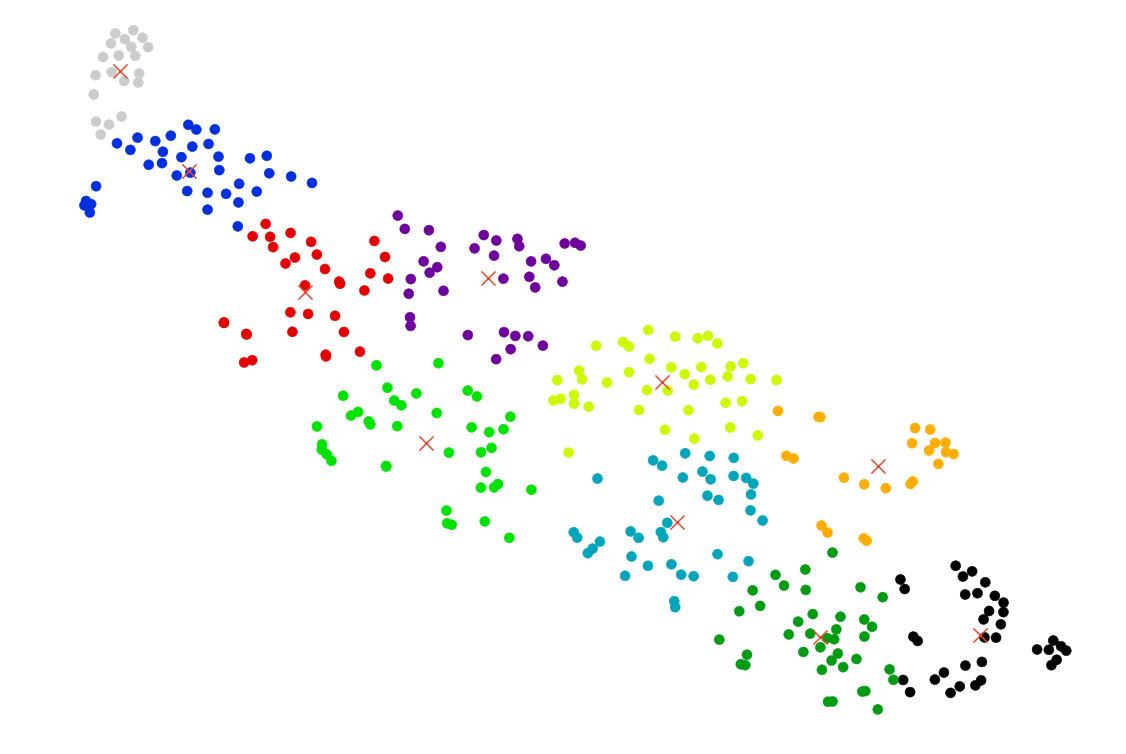

In [354]:
plot_stock_map(coords, labels, symbols, centroids, show_symbols=False)

### Plot the clustering results

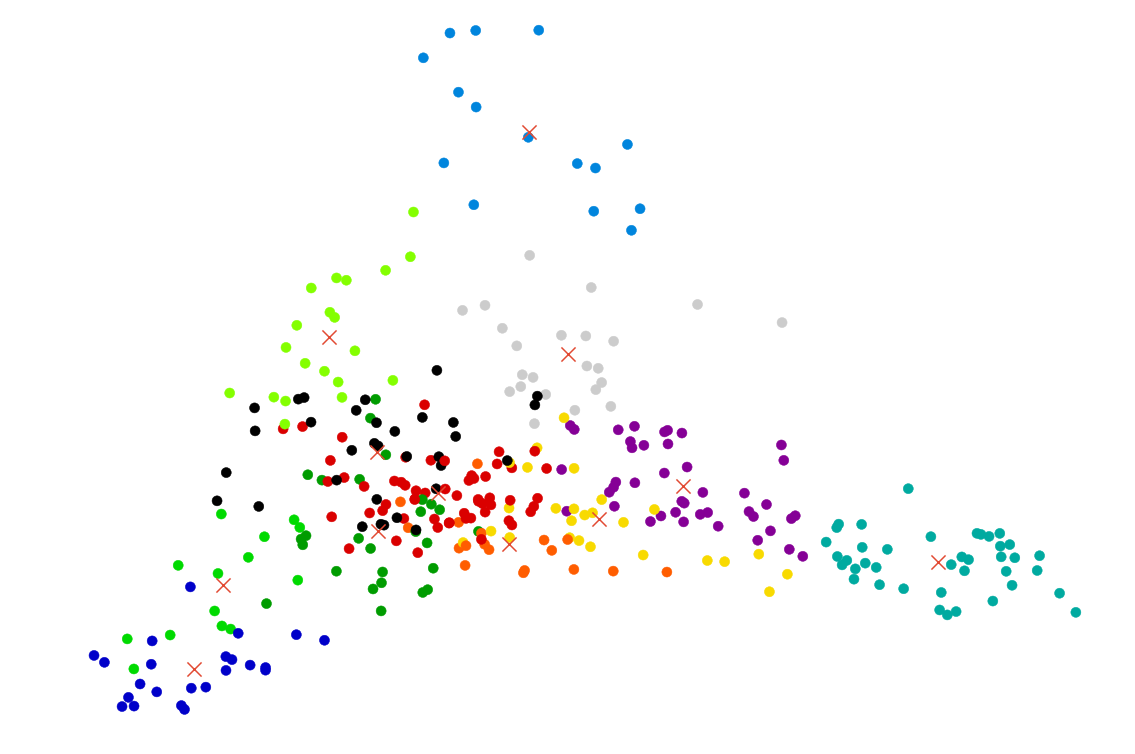

In [343]:
plot_stock_map(coords, labels, symbols, centroids, show_symbols=False)

### Show the map with stock symbols

ValueError: too many values to unpack (expected 2)

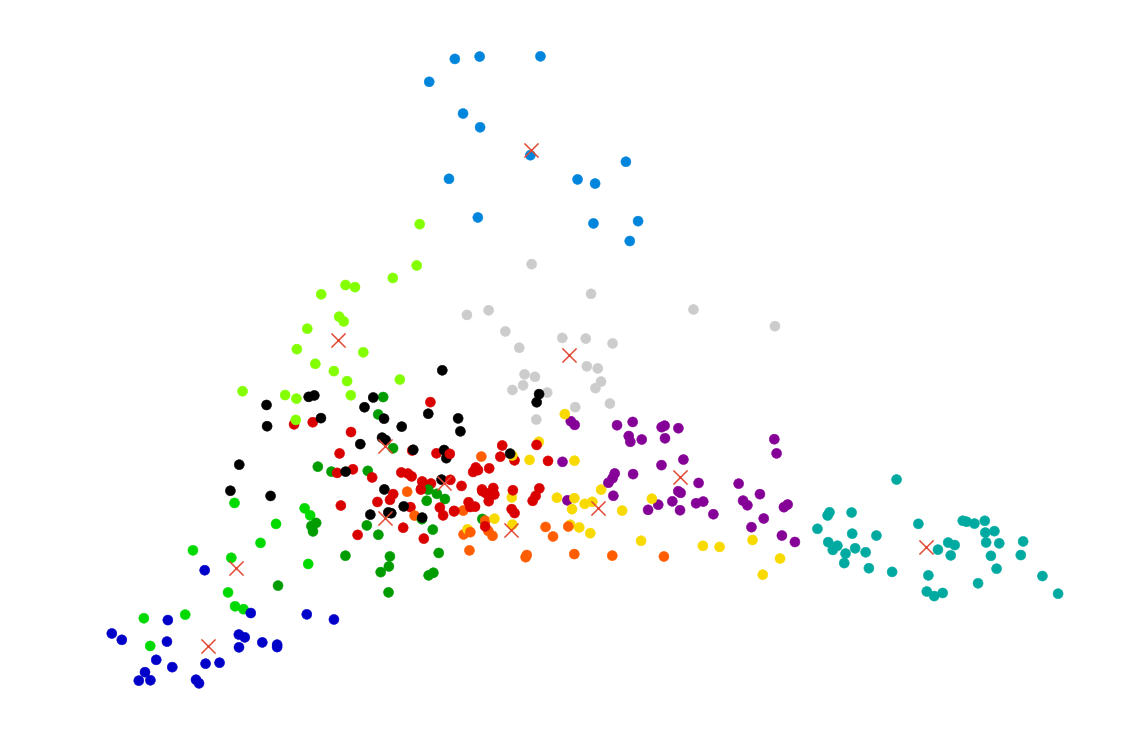

In [342]:
plot_stock_map(coords, labels, symbols, centroids, show_symbols=True)